<center><h1>Machine Learning Pipeline</h1></center>

<h3> 1.a. Introduction </h3>

<blockquote>
    As we explore the exciting field of machine learning, this paper focuses on image classification. Image classification is a significant technique used in a broad range of applications, from medical diagnosis to self-driving cars. <br/><br/>
    This paper serves as a detailed tutorial that explores the topic of binary image classification. I aim to provide a step-by-step guide to understanding the key concepts of binary image classification, which involves classifying images into one of two categories. We will cover the entire process, from data collection and preprocessing, dividing the data into training, validation, and test sets, building a Convolutional Neural Network (CNN) model, training the model, and evaluating its performance.<br/><br/>
    The paper will also include detailed explanations and technical details that will help readers understand the key concepts and techniques used. By the end of this tutorial, you will have a comprehensive understanding of the process of binary image classification and be able to build your own image classification models and implement the suggested extensions.
</blockquote>    

<h3> 1.b. Dependencies </h3>

<blockquote>
    This section brings all the packages into one block for ease of maintainance.
</blockquote>    

In [63]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import f1_score, confusion_matrix
from tensorflow.keras.callbacks import TensorBoard
from scipy.signal import convolve2d, correlate2d 
from tensorflow.keras.utils import plot_model
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
import seaborn as sns
import visualkeras
import numpy as np
import pprint
import imghdr
import cv2
import os

<h3> 1.c. Data Acquisition and Pre-processing</h3>

<blockquote>
    In this section, the focus is on collecting and preprocessing image data. I used online image data since my personal dataset was insufficient to train the model accurately. Additionally, its lack of diversity would limit the robustness of my model. <br/><br/>
    Using the Chrome extension "Download All", I was able to scrape happy and sad images from the web using the keyword searches "happy real people" and "sad real people". The use of the keyword "real" was intended to filter out cartoon or artificially generated images, and to focus on real-life images of people expressing emotions. <br/><br/>
    Once the images were loaded on the web page, the "Download All" extension was used to download all the images on the page as a zip file. This process was repeated for both the happy and sad datasets. I then extracted and sorted into two separate directories for happy and sad images. <br/><br/>
    In the subsequent code cell, we focus on removing irrelevant images and those with incorrect file extensions. It should be noted that this step is unnecessary if your data is already curated. With the cleaned and curated data, we can move on to the next step of the image classification pipeline, which is data loading.
</blockquote>    

In [3]:
def summary_images(folder_name):
    """
        This function gives a summary of the folder contents
    """
    for image_class in os.listdir(folder_name):
        items = len([image for image in os.listdir(os.path.join(folder_name, image_class))])
        print(f"\nFolder '{image_class}' has {items} items.")

In [4]:
def preprocess_images(folder_name, acceptable_extensions, delete_issues):
    """
        This function accesses a given parent folder containing
        children class data and removes files without the acceptable
        extensions
    """
    # This code block find the 'bad' photos and removes them
    for image_class in os.listdir(folder_name): 
        for image in os.listdir(os.path.join(folder_name, image_class)):
            # Creates a path to the image 
            image_path = os.path.join(folder_name, image_class, image)

            try: 
                # Return image extension using imghdr package
                image_ext = imghdr.what(image_path)
                if image_ext not in acceptable_extensions: 
                    print(f'Info: Removing image {image_path}')
                    os.remove(image_path)

            except Exception as e: 
                print(f'Warning: Issue with image {image_path}')
                # optional setting to remove images with issues
                if delete_issues:
                    os.remove(image_path)
                    
    print("\nPre-processing finished")

In [5]:
# The folder name where the data is stored
folder_name = 'downloads\MLP1_data'

# A list of only the extensions we want to work with
acceptable_extensions = ['jpeg', 'jpg', 'bmp', 'png']

# Before preprocessing
summary_images(folder_name)


Folder 'happy' has 184 items.

Folder 'sad' has 180 items.


In [6]:
# Preprocess data
preprocess_images(folder_name, acceptable_extensions, False)

Info: Removing image downloads\MLP1_data\happy\-portrait-of-real-person-in-studio-full-collection-of-diverse-faces-in-this-.jpg
Info: Removing image downloads\MLP1_data\happy\100855402-confident-man-wearing-a-happy-face-mask-with-arms-crossed-real-people-copy-space.jpg
Info: Removing image downloads\MLP1_data\happy\192px.svg
Info: Removing image downloads\MLP1_data\happy\1qNzXZ8l5VqMIL8zwLRTOLA.jpeg
Info: Removing image downloads\MLP1_data\happy\2-real-people-portrait-happy-072842103_prevstill.jpeg
Info: Removing image downloads\MLP1_data\happy\5b9e7d542100003100c5f33e.jpeg
Info: Removing image downloads\MLP1_data\happy\ack-man-portrait-of-real-person-in-studio-full-collection-of-diverse-faces-i.jpg
Info: Removing image downloads\MLP1_data\happy\depositphotos_35208301-stock-photo-happy-couple-with-real-estate.jpg
Info: Removing image downloads\MLP1_data\happy\elings-portrait-of-happy-young-hispanic-man-from-havana-cuba-looking-at-came.jpg
Info: Removing image downloads\MLP1_data\happy\

In [7]:
# After preprocessing
summary_images(folder_name)


Folder 'happy' has 155 items.

Folder 'sad' has 148 items.


<h3> 2. Loading Data </h3>

<blockquote>
    In this section, we focus on converting the data to a format that is readable by Python so that we can take advantage of the vast libraries and tools available in the Python ecosystem, such as np.array, pandas dataframe, or glob, that will allow for manipulation and analysis of the data. <br/><br/>
    I decided to use the image_dataset_from_directory() method from keras utility functions to load and preprocess my image data. This is because it provides a convenient way to load datasets of images with minimal coding effort (literally a single line of code!). This is also makes the pipeline robust for scenarios where we are dealing with large datasets, as we can process and load them in batches, saving time.
</blockquote>    

In [8]:
# Load data onto Keras to create dataset of images
data = tf.keras.utils.image_dataset_from_directory(folder_name)

Found 303 files belonging to 2 classes.


<h3> 3. Exploratory Data Analysis </h3>

<blockquote>
    In this section, we focus on preliminary EDA in order to gain an initial understanding of the dataset and its underlying structure, characteristics, and patterns. Simply, it will allow us to identify potential issues that might affect our model later such as missing values, outliers, or skewness. Because we are dealing with image data we can focus on specific EDA methods.
</blockquote>

<b> What EDA methods are these?</b>
1. Visualizing the images in the dataset to gain a better understanding of the data.
2. Calculating the mean and standard deviation of the pixel values in the images to normalize the data for better training performance.
3. Checking the class balance to ensure that the dataset is not biased towards one class or the other.
4. Checking the size and dimensions of the images to ensure they are consistent and fit for model training. We will do this in the next section.
5. Conducting principal component analysis (PCA) to understand the main features of the data. (Extension)


<b> 3.a. Visualizing sample images</b>


3 samples selected:



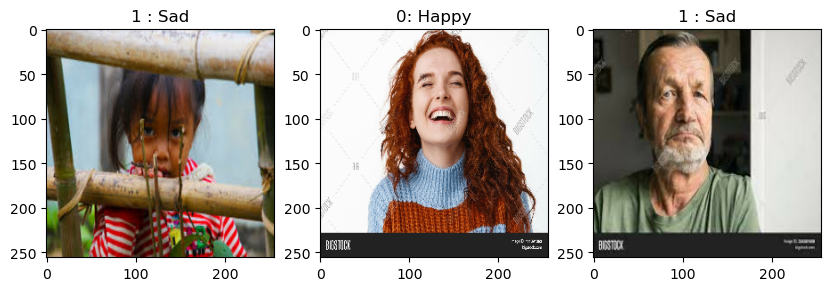

In [16]:
# This creates an iterator to allow us to access the data in batches
data_iterator = data.as_numpy_iterator()

# Create a batch
batch = data_iterator.next()

# Sample n images from batch as proof of concept
n_images = 3
fig, ax = plt.subplots(ncols=n_images, figsize=(10,10))
print(f"\n{n_images} samples selected:\n")

# Create labels dict for the sample images
labels = {1: "1 : Sad", 0: "0: Happy"}

# Plot!!!
for idx, img in enumerate(batch[0][:n_images]):
    # Show images
    ax[idx].imshow(img.astype(int))
    
    # Insert labels
    ax[idx].title.set_text(labels[batch[1][idx]])

<b> 3.b. Descriptive Statistics</b>

<blockquote>
    The mean value of 0.521 indicates that the average pixel intensity value in the dataset is just over halfway between the minimum and maximum values. The standard deviation of 0.314 indicates that the pixel intensity values have a moderate amount of variation around the mean value. Normalizing the mean to 0 and standard deviation to 1 can help the model converge faster during training, improving the optimization problem. Additionally, for image data, as there are various channels (rgb), normalizing brings the pixel values to a similar range, which can be helpful for ensuring that the model treats each feature equally. 
</blockquote>

In [17]:
# Compute the mean and standard deviation of the dataset
mean = np.mean(np.concatenate([x / 255.0 for x, y in data], axis=0))
std = np.std(np.concatenate([x / 255.0 for x, y in data], axis=0))

# print results
print(f"\nMean: {mean:.3f}\nStandard deviation: {std:.3f}")


Mean: 0.521
Standard deviation: 0.314


<b> 3.c. Visualizing the class balance</b>

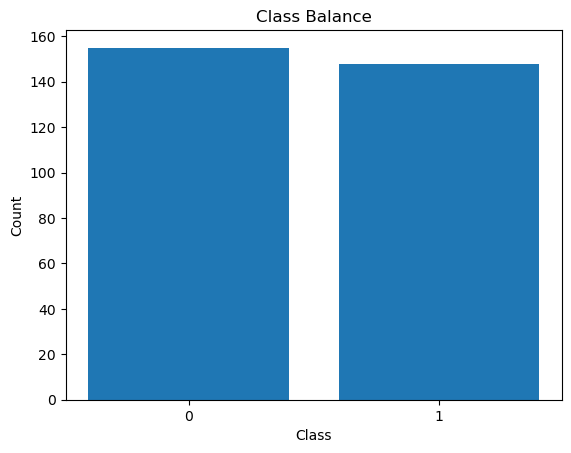

Even balance between the classes. Happy (0): 155, Sad (1): 148


In [18]:
# Get the labels and count the number of images per class
labels = np.concatenate([y for x, y in data], axis=0)
counts = np.unique(labels, return_counts=True)

# Plot the class distribution
plt.bar(np.arange(len(counts[0])), counts[1])
plt.xticks(np.arange(len(counts[0])), counts[0])
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Balance')
plt.show()

# print summary of histogram
print(f"Even balance between the classes. Happy (0): {counts[1][0]}, Sad (1): {counts[1][1]}")

<h3> 4. Task Discussion </h3>

<blockquote>
    In this binary classification task, we will classify images into two categories: happy or sad. To prepare the data for analysis, we will first tokenize the images, which involves converting the image data into a numerical format that a machine learning algorithm can understand. This step is essential because the computer can only process numbers, and images are stored as arrays of pixel values.<br/><br/>
    Once we have this pixel data in a data structure as a numpy array or a keras object, we can normalize it (dividing by 255) to have individual pixel values down to the range [0,1]. Alternatively, a range of [-1,1] can be used. This ensures that the input data to the model is in a normalized range, and it can help the model converge faster during training. Normalizing the data can also help prevent issues such as exploding gradients, which can occur when the input data has a very large range.<br/><br/>
    Once the data is processed, we will split it into training, validation, and testing sets. The training set will be used to train a convolutional neural network (CNN) model for binary classification. During training, the model learns to recognize patterns in the data that are indicative of happy or sad images. The model then uses the validation set to assess how well it is performing, and hence adjust the model's hyperparameters to improve its performance. This is an iterative process that is typically repeated until we obtain the best possible model. Once validated, we test the model on the test set. This provides an unbiased estimate of the model's true performance, and allows us to assess how well the model will generalize to new, unseen image data.<br/><br/>
    To evaluate the performance of our model, we will use various metrics such as accuracy, precision, recall, and F1 score. These metrics provide insight into how well the model is performing on the classification task. A score of 1 indicates that the model performed perfectly, while a score of 0 indicates that the model performed poorly. By assessing the model's performance, we can determine if any adjustments need to be made to improve the accuracy of the model's predictions.
</blockquote>  

<b>Why should we split data?</b>
- Splitting data into training, validation, and test sets is a critical step in the development of any machine learning model. Firstly, by randomly splitting data into the different sets, we prevent any selection bias. Also, it helps us to ensure that we are not making assumptions about the data that are not true, and that we are not overfitting to the training data. Overfitting occurs when a model becomes too good at the training data, that it starts to perform poorly on new data, i.e, it captures all the noise in the data. Through splitting, we can ensure that the model we build is robust, generalizes well, and can be applied to real-world data, (Baheti, 2023).

In [43]:
# Load data onto Keras to create dataset of images
data = tf.keras.utils.image_dataset_from_directory(folder_name)

# Scale the data to values between 0 and 1
data = data.map(lambda x, y: (x/255, y))

# Create numpy iterator
scaled_data = data.as_numpy_iterator()

# From numpy iterator get next batch
batch = scaled_data.next()

# Test that the data is approriate | Expecting max <= 1 and min >= 0
print(f'\nThe first batch photo has max {batch[0].max()} and min {batch[0].min()} values')

# Setting train, validation and test sizes
train_size = int(len(data)*.7)
val_size = int(len(data)*.2)
test_size = int(len(data)*.1)

# Print values of each set | each batch has ~ 20 images
print(f'\nTrain set: {train_size} batches, Validation set: {val_size} batches, Test set: {test_size} batches')

Found 303 files belonging to 2 classes.

The first batch photo has max 1.0 and min 0.0 values

Train set: 7 batches, Validation set: 2 batches, Test set: 1 batches


In [45]:
# Splitting Data using Keras
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size+val_size).take(test_size)

# Confirming correct selection
print(f'\nTrain set: {len(train)} batches, Validation set: {len(val)} batches, Test set: {len(test)} batches')


Train set: 7 batches, Validation set: 2 batches, Test set: 1 batches


<h3> 5. Model Selection </h3>

<blockquote>
    For the model, I decided to use a Convolutional Neural Networks (CNN) as it can be used for binary classification tasks, such as identifying happy or sad sentiments in image data. The model architecture is sequential.
</blockquote>  

<b>How do CNNs work?</b>
- In a convolutional layer of a CNN, each neuron applies a mathematical operation called convolution to a small patch of the input data, using a set of learnable weights, i.e, a kernel of weights is multiplied against the input vector space in a way that neighboring information is condensed into one output. The output of the convolution is then passed through a non-linear activation function, such as the Rectified Linear Unit (ReLU) or sigmoid, which introduces non-linearity into the network and helps to make it more expressive. 
- The resulting feature maps are then downsampled using a pooling operation, which reduces their spatial dimensions while retaining their important features. This downsampling helps to make the network more efficient by reducing the number of parameters and computation required while retaining their important features. 
- By using convolution and pooling operations, CNNs can learn to extract hierarchical representations of the input data, from low-level features like edges and corners to high-level features like objects and scenes. The weights that the network learns for each neuron are shared across all the neurons that connect to the same local receptive field, which reduces the number of learnable parameters and helps to prevent overfitting. This weight sharing also allows the network to efficiently recognize patterns and features in the input data that are present in multiple locations, (LeCun, Bengio, & Hinton, 2015).

<b>How do CNNs differ from NNs?</b>
-  CNNs are a type of neural network that are designed to process data with a grid-like structure, such as images, videos, or audio signals. They are just neural networks where the weights are "shared" between features.
- The "shared weights" in CNNs refer to the way that the network's parameters are learned and applied to different regions of the input data. In a traditional neural network, each neuron in one layer is connected to every neuron in the previous layer. However, in a convolutional layer of a CNN, each neuron is connected to only a small region of the input data, typically a square-shaped patch of pixels which we can stride along, (Shafkat, 2018).

In [46]:
# Define the model
model = Sequential([
    # Add convolutional layers with 16 filters
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
    
    # Add convolutional layers with 32 filters
    Conv2D(32, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    
    # Add convolutional layers with 16 filters
    Conv2D(16, (3,3), 1, activation='relu'),
    MaxPooling2D(),
    
    # Flatten the output of the previous layers
    Flatten(),
    
    # Add a dense layers with 256 units and relu activation
    Dense(256, activation='relu'),
    
    # Add a final dense layer with 1 units and sigmoid activation
    Dense(1, activation='sigmoid')
])

</br>

<b>5 a. What is a sequential model?</b>
- Having a sequential model means that the layers are stacked on top of each other, i.e, a linear stack of layers. Each layer in the network is connected to the preceding and following layers, and information flows through the layers in a sequential order. This makes sequential models well-suited for processing sequential data, such as time series data or natural language data, where the order of the input data is important. 
- In fact, we have seen sequential models before when we worked with feedforward neural netwroks which consisted of an input layer, one or more hidden layers, and an output layer. In a feedforward network, information flows forward from the input layer to the output layer, with no feedback connections.
- In this model, we begin with a convolutional layer with 16 filters, a (3,3) window with a stride of 1. This is followed by a MaxPooling2D layer. Then there is another convolutional layer with 32 filters, followed by another MaxPooling2D layer. Then there is another convolutional layer with 16 filters, followed by another MaxPooling2D layer. The output is then flattened and passed through two dense layers with 256 and 1 units, respectively, with ReLU activation and sigmoid. The latter outputs the probability distribution over the classes.

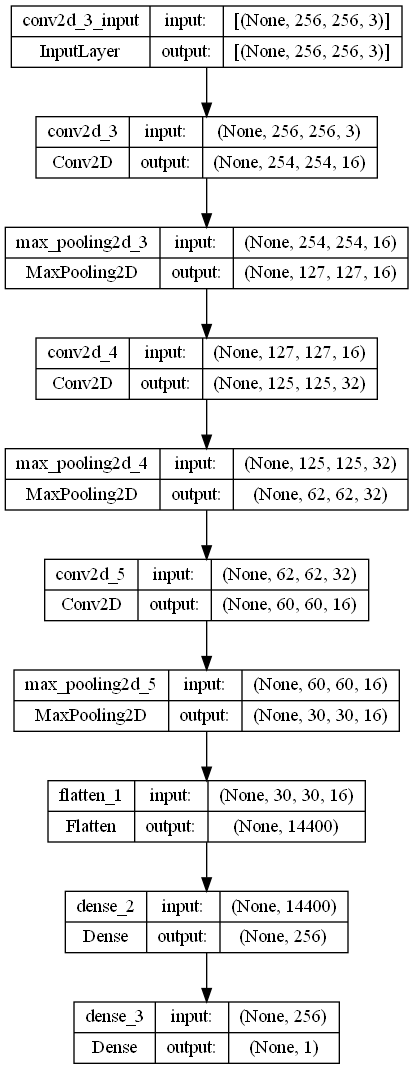

In [47]:
# plot the model as a graph
plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True)

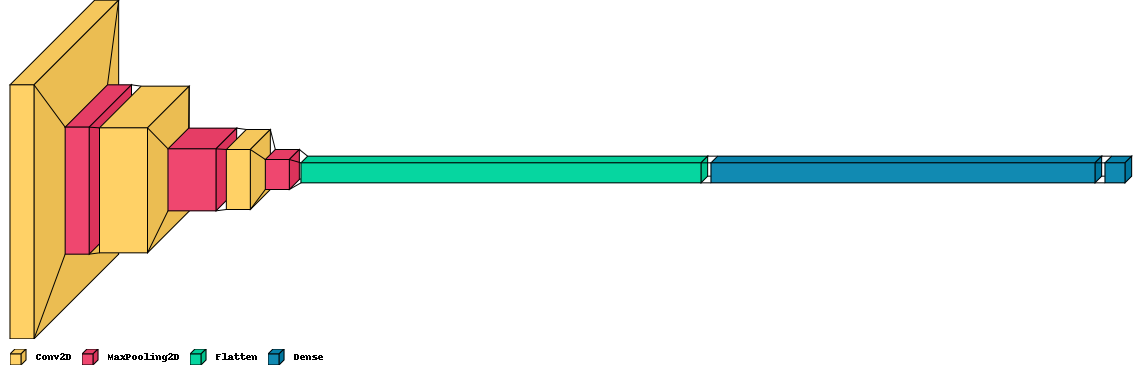

In [48]:
# Visualize the architecture
visualkeras.layered_view(model, legend=True, scale_z=1.5, scale_xy=1.0)

<b>5.b. Purpose of each layer in the selected architecture:</b>
1. Convolutional layer (yellow): 
   - This layer is particularly effective at learning spatial features in image data, which we discussed above under 'how do CNNs work?'. The convolution operation is a mathematical operation that combines the input data with a set of learnable filters, also known as kernels, to extract features that are useful for the downstream tasks, such as image classification.
   - In a convolutional layer, the filters slide over the input data in a sliding window fashion, and the dot product between the filter and the corresponding input data is computed at each position. The result of the convolution operation is a set of feature maps, which capture the presence and distribution of different patterns or structures in the input data. Here, we have used a (3,3) window with a stride of 1.
   - If our data had increasingly complex features, we would use multiple convolutional layers with increasing numbers of filters to allow the model to learn those increasingly complex features.
   - With this understanding, we can discuss the math behind the convolution layer. Where input is the input feature map, output is the output feature map, activation_fn is an activation function such as ReLU or sigmoid, and bias is a scalar bias term. The sum is taken over the filter size and all input feature map channels. The convolution operation applies a set of filters to the input feature map, sliding the filters over the input feature map and computing a dot product at each position to generate a set of activation maps. The activation maps are then passed through an activation function and a bias term is added before being output as the next layer's feature map, (Goodfellow et al., 2016, p. 328). <center>output$[i,j,k] = $activation_fn$( $sum(input$[i:i+F, j:j+F, :] * $filter$[:,:,:,k]) + $bias$[k])$<center/> 
</br></br>

2. Maximum Pooling layers (red): 
   - The basic idea of max pooling is to reduce the size of the feature maps generated by the convolutional layers, while retaining the most important information in the data.
   - During max pooling, the feature maps are divided into small sub-regions or "windows," typically with a size of 2x2 or 3x3 pixels. Within each window, the maximum value is selected and passed on to the next layer, while the other values are discarded. This has the effect of reducing the size of the feature maps by a factor of 2 or 3, depending on the size of the window. The size of the sliding window is determined by a hyperparameter, and the window slides over the feature map in non-overlapping steps.
   - At each position of the sliding window, the max pooling layer selects the maximum value within the window as the output. The output of the max pooling layer is a downsampled feature map that retains the most salient features of the input data. 
   - Max pooling helps to prevent overfitting and improve the computational efficiency of the network. Additionally, because the operation only keeps the maximum value in each window, it helps to preserve the most important information in the data, which is crucial for accurate image recognition.
   - The max pooling operation has several parameters, (Scherer, Müller, & Behnke, 2010, p. 95), where input is the input feature map, output is the output feature map, s is the stride (typically equal to p which is window size), and k represents the depth or number of feature maps. The max pooling operation selects the maximum value within each pooling window and places it in the corresponding position in the output feature map <center>output$[i,j,k] = $max(input$[i*s:i*s+p, j*s:j*s+p, k])$<center/>
</br></br>

3. Flatten layer (green):
   - Flatten layers convert a multidimensional input tensor into a single dimension, which is then fed into a subsequent fully connected (Dense) layer. The Flatten layer essentially reshapes the output of the preceding layer into a 1D array, which can be thought of as a long sequence of values.
   - Here, the 2D downsampled data from the pooling layer is converted into a 1D feature vector that can be fed into a subsequent fully connected layer where matrix multiplication between the flattened input and a weight matrix to generate the final output of the model, i.e, the classification.
   - For example, if the output of the previous layer is a 2D matrix with dimensions (batch_size, 16 x 16), the Flatten layer will reshape it into a 1D vector with dimensions (batch_size, 16 x 16 = 256). 
</br></br>
    
4. Dense layers (blue): 
   - These layers are particularly effective at learning non-linear relationships in the data, which can help the model to make more accurate predictions. In a dense layer, the flattened output of the previous layers is connected to a set of densely connected neurons. Each neuron in this layer receives input from every neuron in the previous layer, and their outputs are used as input for every neuron in the next dense layer.
   - Here, the first Dense layer performs a linear operation on the input, followed by a non-linear activation function. This dense layer has 256 units and adds a Rectified Linear Unit (ReLU) activation function. The ReLU activation function applies the mathematical function f(x) = max(0,x) to each neuron's output, effectively setting all negative values to 0. The number of units in the Dense layer is a hyperparameter that can be tuned to optimize the performance of the model. Increasing the number of units can increase the model's capacity to learn complex relationships between the input and output, but may also increase the risk of overfitting to the training data.
   - In the final dense layer with a single output unit, a sigmoid activation function is added. The sigmoid function transforms the input into a value between 0 and 1, which can be interpreted as a probability. In the context of our binary classification problem, this output of the model represents the probability of the input belonging to a certain class, i.e, either happy (< 0.5) or sad (> 0.5).

In [49]:
# Compile the model
model.compile(optimizer='adam', loss=BinaryCrossentropy(), metrics=['accuracy'])

<b> Understanding the Compile Method </b>
1. Optimizer: This is the optimization algorithm used to train the model. In this case, the optimizer is set to 'adam', which is a popular stochastic gradient descent optimization algorithm that is efficient and requires little memory.

2. Loss: This is the loss function that the model will use to compute the error between the predicted and actual output. BinaryCrossentropy() is a type of cross-entropy loss function that is commonly used for binary classification problems because it can be optimized efficiently using gradient descent methods. It computes the cross-entropy loss between the true labels and the predicted probabilities. The categorical_crossentropy() loss function would be a good choice for multi-class classification tasks, where the goal is to classify input data into one of several classes.

3. Metrics: This is a list of metrics that will be used to evaluate the performance of the model during training and testing. In this case, the metric is set to ['accuracy'], which means that the model's accuracy will be monitored during training and testing. Others metrics include precision, recal, f1score and AUC.

In [50]:
# Summary of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 16)      

<h3> 6. Training the Model </h3>

<blockquote>
    To train our model, we will use the model.fit() method and pass the train and val data sets that we created earlier, along with the number of epochs to train for, which in this case is 20. During the training, the model's performance on the training and validation data is logged using a TensorBoard callback, which stores the training and validation metrics for future access. The training history is also stored in the hist variable. We can use this data to visualize the learning rate of the model, in regards to its accuracy and loss parameters.
</blockquote> 

In [51]:
# Create directory for the logs
logs_directory = 'downloads\logs'

# Create callback that logs training and validation metrics 
# resource: https://www.tensorflow.org/tensorboard/graphs#:~:text=TensorBoard's%20Graphs%20dashboard%20is%20a,how%20TensorFlow%20understands%20your%20program.
tf_callback = TensorBoard(log_dir=logs_directory)

# Train the model and store the training history
hist = model.fit(train, epochs=20, validation_data=val, callbacks=[tf_callback])

Epoch 1/20
7/7 [==============================] - 5s 576ms/step - loss: 0.9009 - accuracy: 0.5223 - val_loss: 0.6675 - val_accuracy: 0.6875
Epoch 2/20
7/7 [==============================] - 4s 466ms/step - loss: 0.6549 - accuracy: 0.6339 - val_loss: 0.6343 - val_accuracy: 0.5938
Epoch 3/20
7/7 [==============================] - 4s 420ms/step - loss: 0.5560 - accuracy: 0.7366 - val_loss: 0.7086 - val_accuracy: 0.5781
Epoch 4/20
7/7 [==============================] - 4s 401ms/step - loss: 0.5760 - accuracy: 0.6384 - val_loss: 0.5774 - val_accuracy: 0.6250
Epoch 5/20
7/7 [==============================] - 4s 422ms/step - loss: 0.4857 - accuracy: 0.8036 - val_loss: 0.4644 - val_accuracy: 0.7812
Epoch 6/20
7/7 [==============================] - 4s 437ms/step - loss: 0.4172 - accuracy: 0.8125 - val_loss: 0.3235 - val_accuracy: 0.8438
Epoch 7/20
7/7 [==============================] - 4s 404ms/step - loss: 0.3234 - accuracy: 0.8571 - val_loss: 0.2582 - val_accuracy: 0.8750
Epoch 8/20
7/7 [====

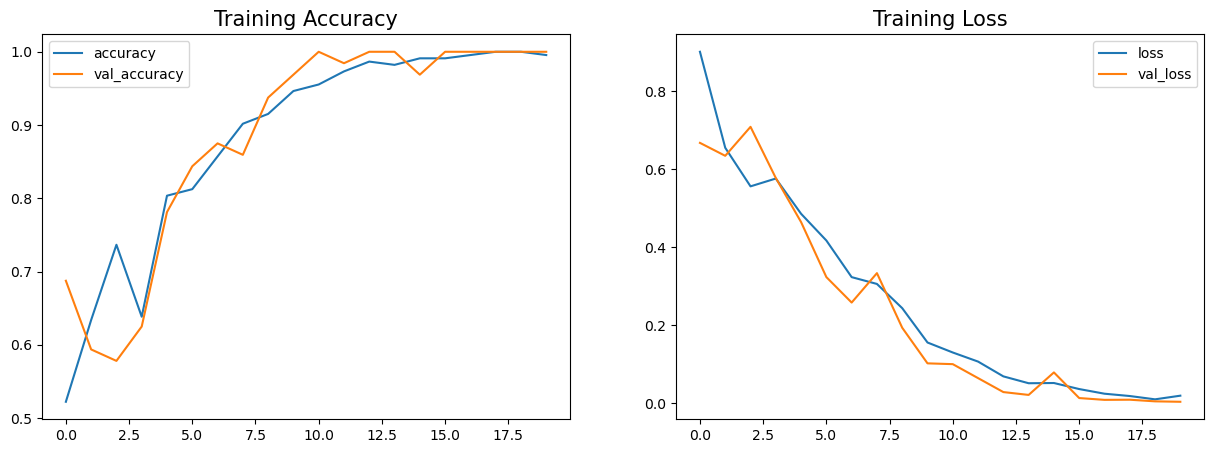

In [52]:
# Plotting the learning history
fig, axs = plt.subplots(1, 2, figsize=(15,5))

# Accuracy plot on the left
axs[0].plot(hist.history['accuracy'], label='accuracy')
axs[0].plot(hist.history['val_accuracy'], label='val_accuracy')
axs[0].set_title('Training Accuracy', fontsize=15)
axs[0].legend(loc="upper left")

# Loss plot on the right
axs[1].plot(hist.history['loss'], label='loss')
axs[1].plot(hist.history['val_loss'], label='val_loss')
axs[1].set_title('Training Loss', fontsize=15)
axs[1].legend(loc="upper right")

plt.show()

<b>What do the plots tell us?</b>
- The plots show us the results we want to see - steady increase in accuracy and steady drop in loss. 

<b>What if we had issues with the results?</b>
1. Hyperparameter tuning: Experiment with different hyperparameters, such as the number of filters, filter size, pooling size in the convolutional layers, different learning rates, batch sizes, and optimizer settings to find the optimal combination of hyperparameters for the model.
2. Regulization: Use regularization techniques such as dropout, L2 regularization, or weight regularization to prevent overfitting.
3. Data augmentation: Use data augmentation techniques to increase the size and diversity of the training dataset. You can generate new examples from existing ones using techniques such as rotation, flipping, and zooming.
4. Callbacks: Use a learning rate schedule, which adjusts the learning rate over time by creating a LearningRateScheduler callback or a ReduceLROnPlateau callback, which reduces the learning rate if the validation loss stops improving for a certain number of epochs. This can help the model to continue to make progress towards better accuracy even if it gets stuck in a local minimum.

<h3> 7. Predictions and Performance </h3>

<b>7.a. Testing on Test Data</b>

In [53]:
# create the evaluation metrics
precision = Precision()
recall = Recall()
accuracy = BinaryAccuracy()

# create the confusion matrix plot function
def plot_confusion_matrix(cm, classes, normalize=False):
    cmap = plt.cm.Blues
    title = 'Normalized Confusion Matrix' if normalize else 'Confusion Matrix'
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    fig, ax = plt.subplots()
    sns.heatmap(cm, annot=True, cmap=cmap, xticklabels=classes, yticklabels=classes)
    ax.set_title(title)
    ax.set_ylabel('True Label')
    ax.set_xlabel('Predicted Label')
    plt.show()


# evaluate the model on the test set
y_true = []
y_pred = []

for batch in test.as_numpy_iterator():
    # unpack batch data
    X, y = batch
    
    # make a prediction using our model
    y_hat = model.predict(X)
    
    # convert the predicted probabilities to class labels
    y_hat = (y_hat > 0.5).astype(int)
    
    # add the true and predicted labels to our lists
    y_true.extend(y)
    y_pred.extend(y_hat)
    
    # update our metrics
    precision.update_state(y, y_hat)
    recall.update_state(y, y_hat)
    accuracy.update_state(y, y_hat)
    
    # calculate f1score
    f1score = f1_score(y, y_hat)

# print the evaluation metrics
print(f'\nPrecision: {precision.result()}, Recall: {recall.result().numpy()}, F1 score: {f1score}, Accuracy: {accuracy.result()}')

1/1 [==============================] - 0s 153ms/step

Precision: 1.0, Recall: 1.0, F1 score: 1.0, Accuracy: 1.0


<b>Performance of our model:</b>

Overall, this is an excellent result with perfect classification performance. Precision, Recall and Accuracy all score 1.0/1.0.

<b>Why might a model have poor performance?</b>
 1. Insufficient data: Deep learning models require large amounts of data to learn meaningful patterns. If the model is not provided with enough training data, it may not be able to learn the relevant features required to make accurate predictions.
 2. Poor quality data: If the data is noisy, inconsistent, or biased, it can be difficult for the model to learn meaningful patterns. This can lead to poor performance on both the training and test sets.
 3. Inappropriate architecture: Choosing the right architecture for a given task is important. If the model is too simple, it may not be able to capture the complexity of the data. Conversely, if the model is too complex, it may overfit to the training data and not generalize well to new data.
 4. Inappropriate hyperparameters: Hyperparameters such as learning rate, batch size, and regularization strength can have a significant impact on the performance of the model. If these are not chosen carefully, the model may not be able to learn the relevant patterns.
 5. Lack of diversity in the data: If the training data is not diverse enough, the model may not be able to generalize well to new data from different distributions.
 6. Inappropriate loss function: Choosing the right loss function is important, as it determines what the model is optimizing for. If the loss function is not appropriate for the task, the model may not be able to learn the relevant patterns.

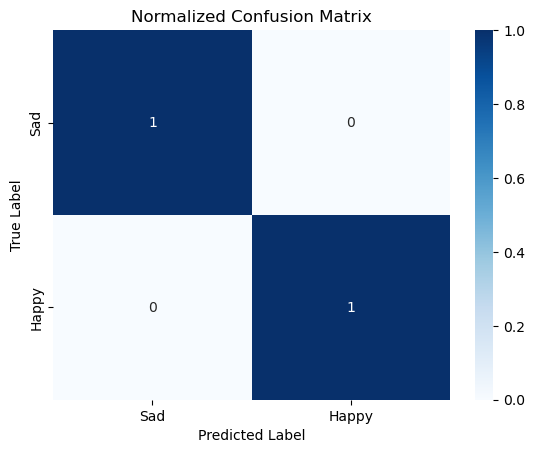


Confusion Matrix:
 [[12,  0],
 [ 0,  3]]


In [55]:
# compute and plot the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# plot the confusion matrix
plot_confusion_matrix(cm, classes=['Sad', 'Happy'], normalize=True)

# print the confusion matrix
print("\nConfusion Matrix:\n", np.array2string(np.array(cm), separator=', ', formatter={'int': lambda x: f'{x:2d}'}))


<b>What does the confusion matrix represent?</b>
- The confusion matrix above represents a binary classification problem, where there are two possible classes. 
- The actual class labels are on the vertical axis and the predicted labels are on the horizontal axis. 
- In this case, the class labels are "0" and "1", and "0" is the positive class (happy) while "1" is the negative class (sad).
- The confusion matrix shows that there are a total of 15 test samples.

<b>How do we interpret the confusion matrix?</b>

- The first row of the confusion matrix shows the performance of the classifier on the positive class. The entry at (1,1) shows that the classifier predicted 12 true positive samples, which means that the classifier correctly identified all positive samples. The entry at (1,2) shows that the classifier predicted 0 false negative samples, which means that the classifier did not miss any positive samples.

- The second row of the confusion matrix shows the performance of the classifier on the negative class. The entry at (2,1) shows that the classifier predicted 0 false positive samples, which means that the classifier did not misclassify any negative samples. The entry at (2,2) shows that the classifier predicted 3 true negative samples, which means that the classifier correctly identified all negative samples.

<b>7.b. Testing on Personal Data</b>

In [56]:
def classify_image(image_path, show_image = False): 
    """
        This function takes an image path and returns its binary
        classification of happy/sad with the option to display
        the image.
    """
    #read image
    img = cv2.imread(image_path)
    
    # resize image
    resize = tf.image.resize(img, (256,256))
    
    #plot image
    if show_image:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    
    # classify
    yhat = model.predict(np.expand_dims(resize/255, 0))
    
    if yhat > 0.5: 
        print(f"\nImage '{image_path}' classification {float(yhat):.3f}: Sad")
    
    else:
        print(f"\nImage '{image_path}' classification {float(yhat):.3f}: Happy")

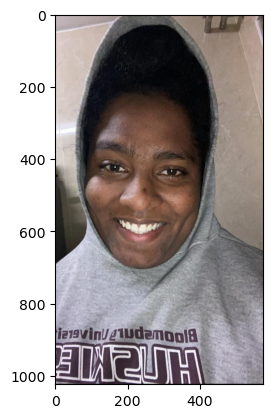

1/1 [==============================] - 0s 23ms/step

Image 'downloads/happy.jpeg' classification 0.001: Happy


In [57]:
# testing to see if a happy photo is detected as happy
classify_image('downloads/happy.jpeg', True)

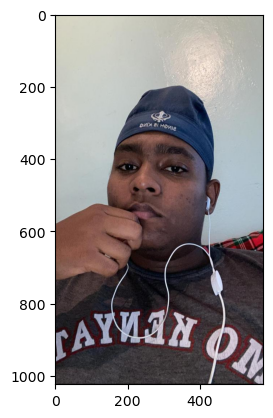

1/1 [==============================] - 0s 20ms/step

Image 'downloads/sad.jpeg' classification 1.000: Sad


In [58]:
# testing to see if a sad photo is detected as sad
classify_image('downloads/sad.jpeg', True)

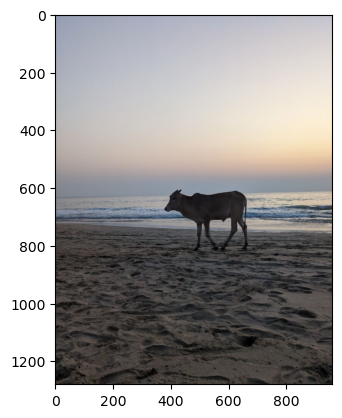

1/1 [==============================] - 0s 16ms/step

Image 'downloads/seacow.jpg' classification 0.951: Sad


In [59]:
# testing to see what an ambigious photo is detected as :)
classify_image('downloads/seacow.jpg', True)

<h3> 8. What's under the Hood?</h3>

<blockquote>
    In this section, we will focus on filters and biases. Specifically, comparing the filters and biases across different layers to see how they differ and how they contribute to the overall performance of the model.  
</blockquote>

<b> Why filters and biases? </b>
 - Now that we have seen that our model works for unseen data, we may begin to ask, then why does it work? [Appendix A](#code_works). 
- We know that we have layers, and we discussed the architecture of these layers but we might want to go deeper to the filters and biases applied at each layer to better understand what's going on. 
- Visualizing a layer's filters and biases can provide insight into what the layer is doing and what features it is learning.

<b> What are filters?</b>
-  Filters are small matrices of weights that are used to scan over an input image or other data to perform a convolution operation. In a convolutional neural network (CNN), each layer is composed of a set of filters that are learned during the training process. These filters are designed to detect specific features in the input data, such as edges, corners, or blobs.
- This operation can be thought of as a sliding window that scans over the input data and computes a weighted sum of the values within the window. The weights in the filter matrix determine how the sum is computed, and different filters can be designed to detect different features. By using multiple filters in each layer of a CNN, the network can learn to detect a wide range of features at multiple scales.
- The specific values in the filter matrix are learned during the training process using backpropagation, and are adjusted to minimize the loss function for the given task, i.e, to detect relevant features.

<b> What are biases?</b>
- Biases are additional learnable parameters that are used in conjunction with filters in a convolutional neural network (CNN). They are essentially scalar values that are added to the output of each filter in a given layer.
- The role of biases in a CNN is to allow the model to learn more complex and non-linear functions, by shifting the output of each filter. Without biases, the output of each filter would be limited to a linear transformation of the input data. By introducing biases, the model can learn to shift the activation function of each filter along the x-axis, enabling it to capture more complex features and patterns in the data.
- Similar to filters, they are also learned through backpropagation during the training process.<center>Output = Convolution(input, filter) + Bias<center/>

<h3> 8.a. Let's build a simple filter </h3>
    
- A simple edge detection filter such as the Sobel filter, is a 3x3 matrix that is applied to an image to detect its vertical edges and horizontal edges. Let's visualize them below, then apply them to an image

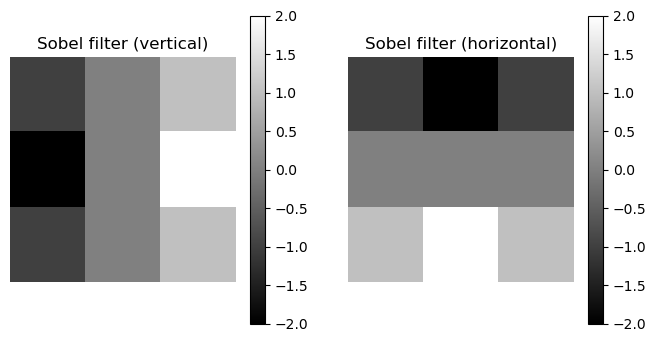

In [60]:
# Vertical Sobel filter
sobel_v = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])

# Horizontal Sobel filter
sobel_h = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])

# Plot the filters side by side
fig, axs = plt.subplots(1, 2, figsize=(8, 4))

im0 = axs[0].imshow(sobel_v, cmap='gray')
axs[0].set_title('Sobel filter (vertical)')
axs[0].axis('off')
plt.colorbar(im0, ax=axs[0])

im1 = axs[1].imshow(sobel_h, cmap='gray')
axs[1].set_title('Sobel filter (horizontal)')
axs[1].axis('off')
plt.colorbar(im1, ax=axs[1])

plt.show()

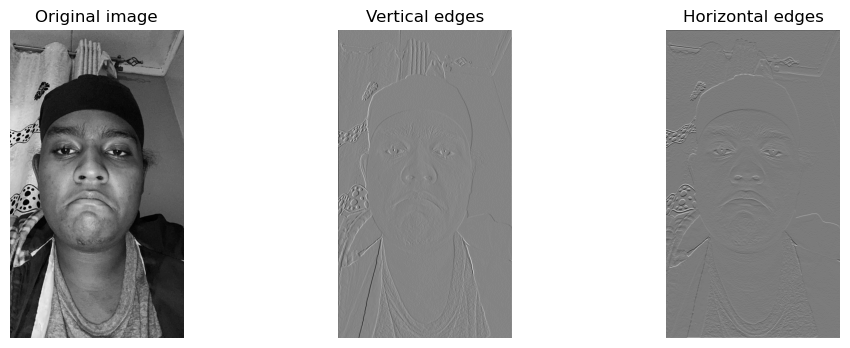

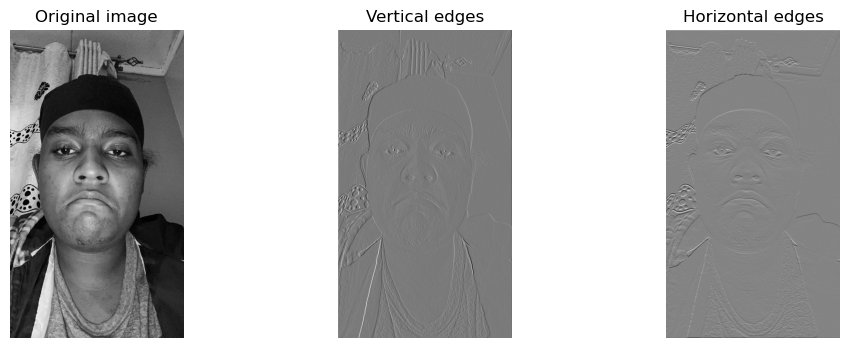

In [64]:
# source: https://forum.minerva.edu/app/courses/2591/sections/10236/classes/72553
# Load an image and convert it to grayscale
img = np.array(Image.open('downloads/filter.jpeg').convert('L'))

# Apply the vertical and horizontal Sobel filters to the image
# Note: either convolve2d or correlate2d can be used here, convolve doesnt flip the filter
edges_v = convolve2d(img, sobel_v, mode='same')
edges_h = convolve2d(img, sobel_h, mode='same')

# Plot the original image and the filtered images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(edges_v, cmap='gray')
axs[1].set_title('Vertical edges')
axs[1].axis('off')

axs[2].imshow(edges_h, cmap='gray')
axs[2].set_title('Horizontal edges')
axs[2].axis('off')

plt.show()

# Correlate2d
edges_v = correlate2d (img, sobel_v, mode='same')
edges_h = correlate2d (img, sobel_h, mode='same')

# Plot the original image and the filtered images
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original image')
axs[0].axis('off')

axs[1].imshow(edges_v, cmap='gray')
axs[1].set_title('Vertical edges')
axs[1].axis('off')

axs[2].imshow(edges_h, cmap='gray')
axs[2].set_title('Horizontal edges')
axs[2].axis('off')

plt.show()

# as you can observe below either function can be used, as long as the filter is oriented correctly.

<b> What about the filters in the CNN's Convolution layer? </b>
- The filters in the CNN are bit more complex, beyond my full understanding, but as we will tell in the coming subsections, they are not explicitly designed to detect edges, unlike the Sobel filters which are specifically designed for edge detection. Be that as it may, the filters in the Conv2D layer may still capture edge information if this is a key feature for the classification, i.e, if it learns it.
- The filters in the Conv2D layer are randomly initialized and then updated during training through backpropagation, with the objective of minimizing the loss function. These filters are learned by the model through a process of feature extraction, where the model tries to find patterns in the input data that are relevant to the task it is trying to perform.
- The Sobel filters are simple, fixed filters that can be used as a pre-processing step before passing the image through the Conv2D layer. This woul d increase convergence time, as it provides a way to explicitly extract edge information from the input images, which can help the model learn faster.
- Another thing to note is the size of the filter. While the Sobel filters are 3x3, the Conv2D layers can be very large. In our model, the first convolution layer is 16x3x3x3. Let's try to visualize the filters of this layer with a sample_model.

In [65]:
# Define the sample model
sample_model = Sequential([
    # Add convolutional layers with 16 filters
    Conv2D(16, (3,3), 1, activation='relu', input_shape=(256, 256, 3)),
    MaxPooling2D(),
])

# Get the filters from the first convolutional layer
filters, biases = sample_model.layers[0].get_weights()

# what do the biases look like the? 
# We expect the biases to be 0 as we have yet to train this sample_model
print(f"\nBiases shape: {biases.shape}")
print(f"\nBiases: {biases}")


Biases shape: (16,)

Biases: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [66]:
# what does the filter matrix look like? Not very pretty
print(f"\nFilter shape: {filters.shape}")
print(f"\nFilter: {filters}")


Filter shape: (3, 3, 3, 16)

Filter: [[[[-0.17224887 -0.10993591 -0.07807197  0.0065241   0.11807513
     0.03874925  0.08997294  0.00400725  0.01631251 -0.16442843
    -0.11996991 -0.0383859  -0.03779803  0.0430056  -0.1633959
    -0.0483622 ]
   [-0.09706876  0.003653    0.1751222  -0.13501422  0.02487056
    -0.15172091  0.11077833  0.03628661 -0.12841576 -0.13185109
     0.09399232  0.02344096  0.09917465  0.14104474 -0.15690927
    -0.09066012]
   [ 0.15218234 -0.12441102  0.07468307  0.09978881 -0.14203614
     0.12288719  0.12722826  0.10570911 -0.12855229 -0.00916216
     0.17433485  0.17151591 -0.11942756  0.08882388 -0.08071708
     0.13344243]]

  [[-0.1378708   0.07561076  0.02005863  0.11369038  0.05046153
    -0.08325645  0.10623369 -0.06724132  0.1550611  -0.06319737
    -0.02595146 -0.06676909  0.0991407  -0.05161151 -0.04682121
     0.08101559]
   [ 0.04630436  0.10281587 -0.07375746  0.17500049  0.12303844
     0.03304203 -0.15509474 -0.0599715   0.13446173  0.065229

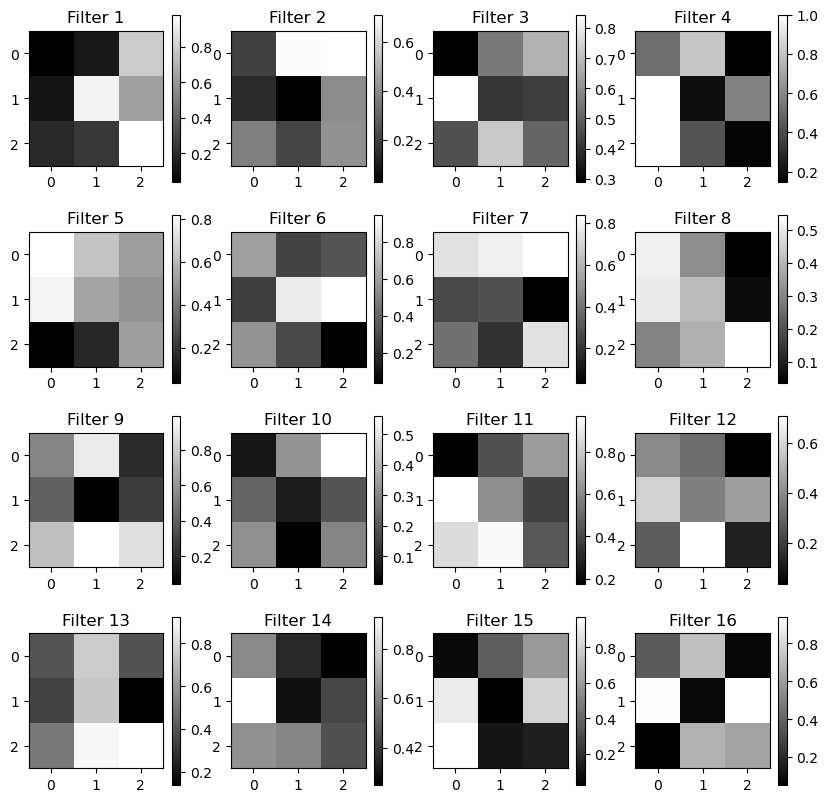

In [67]:
# Let's visualize the filter like before!

# Normalize filter values to 0-1 so we can visualize them
f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

# Plot the filters
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(10, 10))
for i, ax in enumerate(axs.flat):
    if i < filters.shape[3]:
        im = ax.imshow(filters[:, :, 0, i], cmap='gray')
        ax.set_title(f'Filter {i+1}')
        plt.colorbar(im, ax=ax)

plt.show()

<h3> 8.b. Visualizing the effect of filters on input image data </h3>

<blockquote>
    Now that we have a rough idea of what the filters in the sample model look like, let's revert to our model and see how applying these filters transforms the input image data. Let's focus only on the convolutions layers. As we'll see, some of the filters focus on blobs, some on vertical edges, and some on horizontal edges. Others just shift the colormap.
</blockquote>

In [75]:
def image_filters(image_path, layer, show_og=False, show_filters=True, nr=4, nc=4):
    """
        This is a function that provides a summary of the filters
        applied at a given layer, for a given image with the option
        to visualize the filtering of the images.
    """
    #read image
    img = cv2.imread(image_path)

    # resize image
    resize = tf.image.resize(img, (256,256))

    if show_og:
        #plot original image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.show()
    
    # classify
    x_data = np.expand_dims(resize/255, 0)

    # Select the layer to visualize
    layer_to_visualize = layer

    # Create a new model that outputs the outputs of the chosen layer
    visualization_model = Model(inputs=model.input, outputs=model.layers[layer_to_visualize].output)

    # Get the filters for the chosen layer
    filters = visualization_model.predict(x_data)
    
    # Print the layer name, filter shape, and any relevant biases
    layer = model.layers[layer_to_visualize]
    
    # Print the biases array in a pretty format
    biases = layer.get_weights()[1]
    biases_list = biases.tolist()
    pp = pprint.PrettyPrinter(indent=8, compact=True)

    if 'conv' in layer.name:
        print(f"\nLayer name: {layer.name}")
        print(f"\nFilter shape: {layer.get_weights()[0].shape}")
        print(f"\nBiases:")
        pp.pprint(biases_list)

    if show_filters:
        # Plot the filters
        fig, axes = plt.subplots(nrows=nr, ncols=nc, figsize=(10,10))
        for i, ax in enumerate(axes.flat):
            ax.imshow(filters[0,:,:,i], cmap='gray')
            #ax.axis('off')
        plt.show()

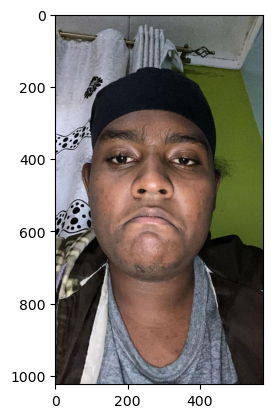

1/1 [==============================] - 0s 41ms/step

Layer name: conv2d_3

Filter shape: (3, 3, 3, 16)

Biases:
[       0.016585782170295715, 0.004334616009145975, 0.0064369202591478825,
        0.00023033654724713415, 0.003357355482876301, -0.0060451035387814045,
        0.005284142680466175, -0.007859866134822369, 0.0076987710781395435,
        -0.012929972261190414, 0.012072236277163029, -0.008713733404874802,
        -0.01007765717804432, 0.005447935778647661, -0.004215057007968426,
        -0.001440458814613521]


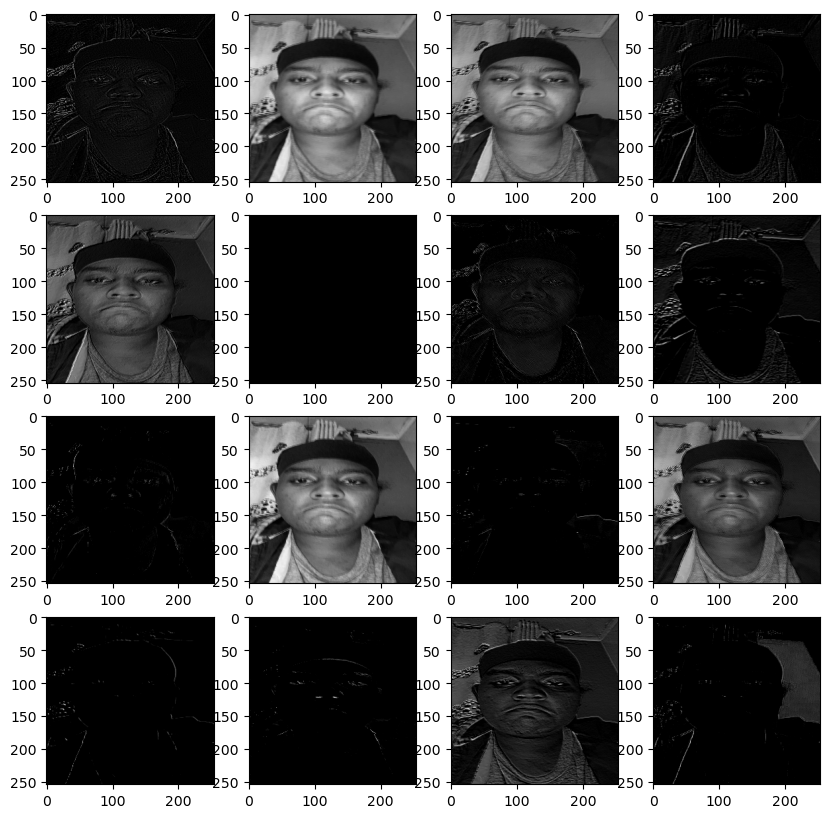

In [70]:
# first convolution layer 
image_filters('downloads/filter.jpeg', 0, True)

1/1 [==============================] - 0s 58ms/step

Layer name: conv2d_4

Filter shape: (3, 3, 16, 32)

Biases:
[       -0.0024800735991448164, 0.01880725286900997, -0.004902619402855635,
        -0.0071634273044764996, 0.004286408890038729, 0.010890459641814232,
        0.008105765096843243, 0.020864609628915787, 0.01814662292599678,
        0.012870646081864834, 0.02544555626809597, 0.026546766981482506,
        -0.010227997787296772, 0.0380781888961792, 0.0044256411492824554,
        0.02367936633527279, -0.00651932880282402, -0.010358491912484169,
        -0.006500144489109516, -0.005409087520092726, -0.0007802930194884539,
        -0.004531179554760456, -0.00548742339015007, 0.011613298207521439,
        0.014583826996386051, -0.010148325003683567, -0.0076581817120313644,
        0.0028568669222295284, -9.029731700138655e-06, 0.0293903686106205,
        -0.005477735307067633, -0.0018176902085542679]


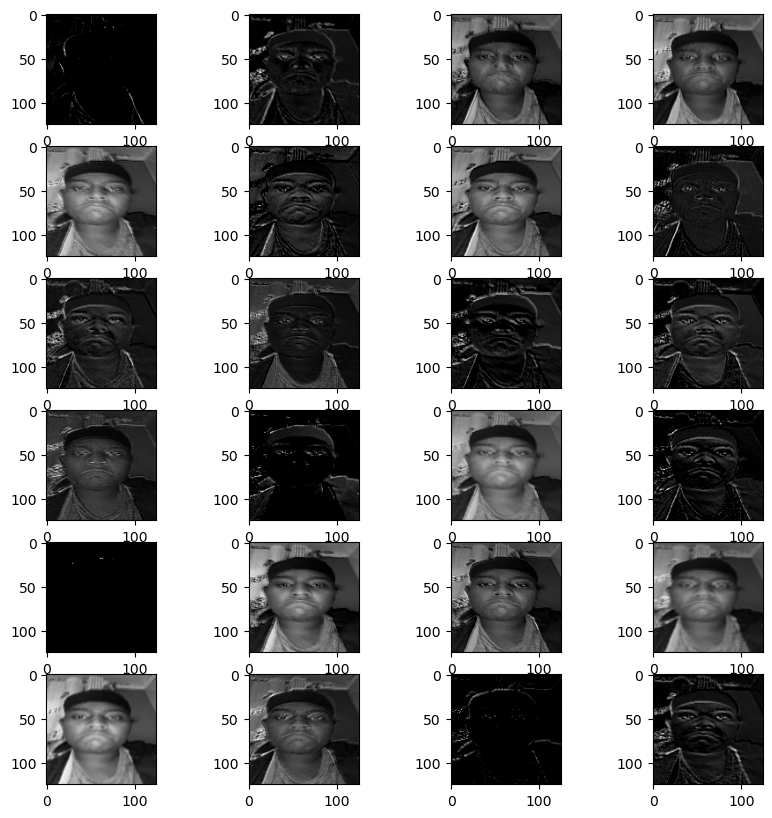

In [71]:
# second convolution layer
image_filters('downloads/filter.jpeg', 2, False, 5, 6)

1/1 [==============================] - 0s 52ms/step

Layer name: conv2d_5

Filter shape: (3, 3, 32, 16)

Biases:
[       0.01565566286444664, -0.015389259904623032, -0.009383350610733032,
        0.011863110587000847, -0.007489549927413464, -0.007232534699141979,
        0.008333965204656124, -0.007263512350618839, -0.0049570403061807156,
        0.006686318200081587, -0.0023049369920045137, 0.003487858921289444,
        -0.00671031977981329, 0.00193266780115664, -0.006645045708864927,
        -0.005503916647285223]


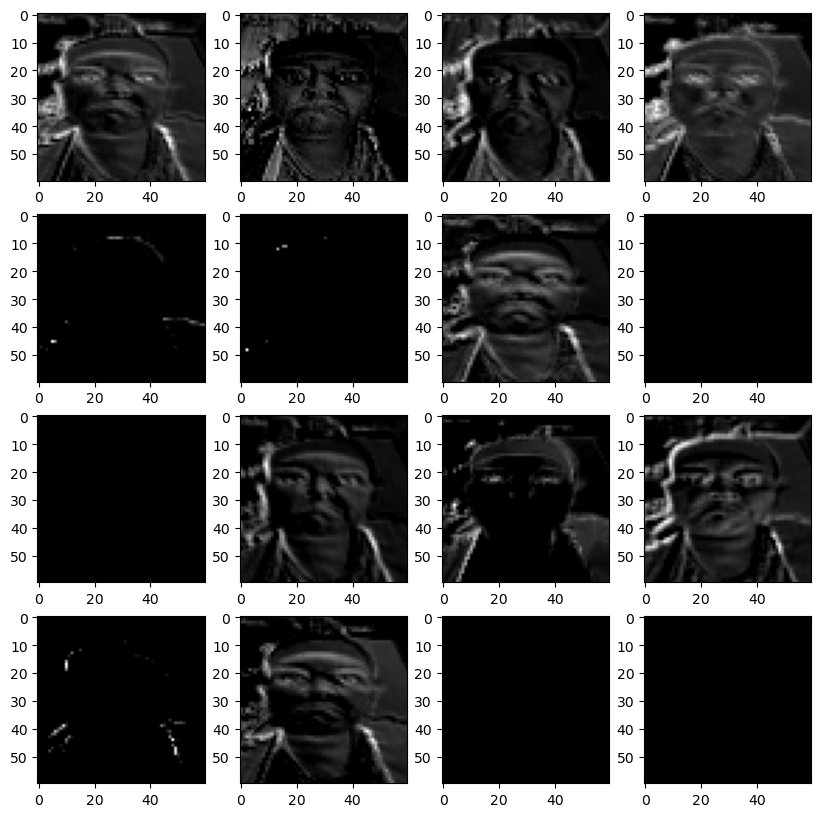

In [76]:
# last convolution layer
image_filters('downloads/filter.jpeg', 4, False)

<b> Why was this an important section to cover? </b>

There are a couple of reasons (LeCun, Bengio, & Hinton, 2015): 

1. Understanding what the layer is looking for: The filters in a convolutional layer can be thought of as a set of templates that the layer uses to detect specific features in the input data. By visualizing the filters, you can get a sense of what kind of features the layer is trying to detect. For example, if the filters are detecting diagonal lines or edges, you can infer that the layer is looking for edges and other simple features in the input data.

2. Debugging the model: Visualizing the filters and biases can help you identify potential problems with the model. For example, if the filters are all the same or all zero, it might indicate that the model is not training properly or that the input data is not varied enough. Remember when we found the biases of the sample_model to be zeros?

3. Improving the model: Visualizing the filters and biases can also help you improve the model. For example, if the filters are not detecting the features you want, you might need to adjust the model architecture, increase the number of filters, or use different filter sizes.

<h3> 9. Summary </h3>

<blockquote>
    In this project, we have created an ML pipeline to classify happy and sad sentiments using a Convolutional Neural Network (CNN). We focused not only on building the model but also on understanding the underlying concepts that make the pipeline work. By doing this, we were able to gain a deeper understanding of the machine learning techniques and the architecture of the neural network. Our pipeline uses image preprocessing, data loading, and model training to achieve high classification accuracy. Overall, this project showcases our ability to not only implement machine learning techniques but also to deeply understand the principles that make them work.
</blockquote>
    
 <b> I am an ML nut - what extensions can I do? </b>
1. Fine-grained sentiment analysis: Instead of just classifying images as happy or sad, you could perform fine-grained sentiment analysis and assign a sentiment score to each image. This would require training the model on a larger dataset with more nuanced labels, such as "very happy" or "slightly sad." Alternatively, you could cheekily decide y_hat values > 0.75 are "very sad" and y_hat values < 0.25 are "very happy".
2. Multi-class classification: Instead of just classifying images as happy or sad, you could expand the classifier to include other emotions, such as anger, fear, or surprise. This would require retraining the model on a larger dataset that includes images of different emotions. 
3. Data augmentation: You could augment the dataset by applying random transformations to the images, such as rotation, scaling, or flipping. This would increase the size of the dataset and help the model generalize better to new images. 
4. Ensemble learning: You could train multiple CNNs with different architectures or hyperparameters, and then combine their predictions to improve accuracy. This can often improve performance compared to a single model. 
5. Transfer learning: You could use a pre-trained model such as VGG, ResNet or EfficientNet and fine-tune it for your specific task. This would allow you to train a more accurate model with less data, since the pre-trained model has already learned many features from a large dataset.


<b> How do I reuse this model for other projects or deployment? </b>
- The tensorflow package makes this a very simple process. See the code cell below.

In [ ]:
# saving the model; specify the directory and name of the model
model.save(os.path.join('downloads','MLP1-binary-image-classifier.h5'))

In [ ]:
# loading the model for other projects
loaded_model = load_model('downloads/MLP1-binary-image-classifier.h5')

<h3> 10. References </h3>

Baheti, P. (2023). Train Test Validation Split: How To & Best Practices. Blog.
https://www.v7labs.com/blog/train-validation-test-set

Goodfellow, I., Bengio, Y., & Courville, A. (2016). Convolutional Networks. In Deep Learning (pp. 327-388). MIT Press. https://www.deeplearningbook.org/contents/convnets.html

LeCun, Y., Bengio, Y., & Hinton, G. (2015). Deep learning. Nature, 521(7553), 436-444. https://doi.org/10.1038/nature14539

Pathshala. (2021) [Video]. Feature Maps Visualization Of CNN | Interpretation Of Output Of Conv2D And Maxpooling Layer. Youtuve. https://www.youtube.com/watch?v=i3qjgJgQqgg

Scherer, D., Müller, A., & Behnke, S. (2010). Evaluation of Pooling Operations in Convolutional Architectures for Object Recognition. International Conference on Artificial Neural Networks (pp. 92-101). Springer, Berlin, Heidelberg. https://doi.org/10.1007/978-3-642-15825-4_10

Shafkat, I. (2018, June 1). Intuitively Understanding Convolutions for Deep Learning. Towards Data Science.
https://towardsdatascience.com/intuitively-understanding-convolutions-for-deep-learning-1f6f42faee1

<h3> 11. Appendix </h3>

<h5> A. The Code Works </h5>

<a id='code_works'></a>

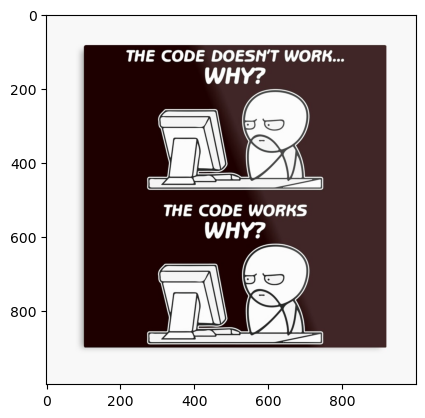

In [74]:
#read image
img = cv2.imread('downloads/meme.jpg')
    
# resize image
resize = tf.image.resize(img, (256,256))
    
#plot image
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()